# Comparison between ISOMAP, LLE, LTSA
## 1. Real-world data

Our aim is to compare the results of three methods of non-linear dimensionality reduction on some data from the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database); we extracted from the database the 60.000 images of handwritten digits used as a training dataset.

The data are contained in a .csv file, in the format
`label, pixel1, pixel2, pixel3, ...., pixel784`
where for each pixel is given the gray value and label is a number from 0 to 9. We start by reading the file and building our database of images, divided accordingly to the digit they represent.

We also load `numpy` and `matplotlib` modules to perform computations and plot our results; the NLDR algorithms are contained in `sklearn.manifold` and `time` has an obvious role.



In [3]:
%matplotlib notebook
from sklearn import manifold
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt

image_size = 28                         # width and length
image_pixels = image_size * image_size  # number of pixels per image (don't know if we will need it...)
data_path = ""                          # directory where the dataset is

train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter=",")  # reads data from the mnist training dataset

images=[]                               # array of arrays of images, according to the digit
for j in range(10):
    images.append(train_data[train_data[:,0]==j]) # we create the list of the images for the digit j
    images[j]=images[j][:,1:]                     # we remove the label from each image

In [4]:
# For fun, we spell out the number of images in the dataset, according to the digit
print("The MNIST training dataset contains:")
print("\n".join(["%d images with handwritten versions of the digit %d"%(len(images[j]),j) for j in range(10)]))
print("for a grand total of %d images."%len(train_data))

The MNIST training dataset contains:
5923 images with handwritten versions of the digit 0
6742 images with handwritten versions of the digit 1
5958 images with handwritten versions of the digit 2
6131 images with handwritten versions of the digit 3
5842 images with handwritten versions of the digit 4
5421 images with handwritten versions of the digit 5
5918 images with handwritten versions of the digit 6
6265 images with handwritten versions of the digit 7
5851 images with handwritten versions of the digit 8
5949 images with handwritten versions of the digit 9
for a grand total of 60000 images.


To better understand what kind of material we are working with, the following code draws some samples from one of the digits and plots them. Change the variables `digit`, `n_hor`, `n_ver` in the next cell to explore the dataset; just re-run the second cell to see another sample with the same parameters.

In [5]:
digit=2                               # the digit we want to see some samples of
n_hor=5                               # number of columns
n_ver=3                               # number of rows

<IPython.core.display.Javascript object>


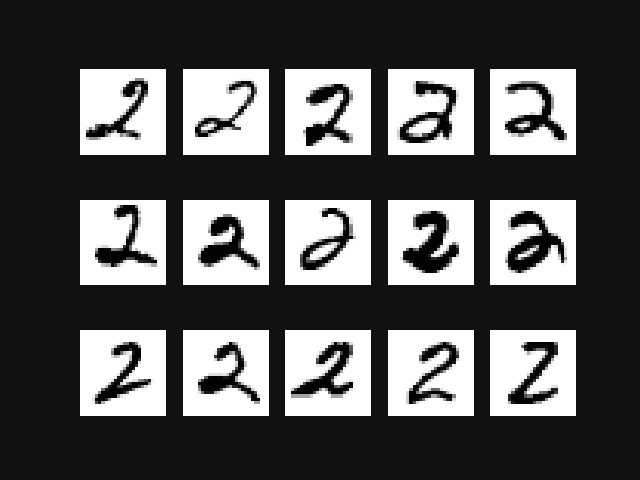

In [6]:
sz_ex=n_hor*n_ver                         # we draw some random small sample to exemplify the kind of images_
                                          # we are dealing with
img_nums = np.random.randint(0, len(images[digit]), size=sz_ex) 

fig, ax=plt.subplots(n_ver,n_hor)         # we arrange them in a table 
fig.set_facecolor('#111')                 # same background color of the lectures' slides
assi=[it for sbl in ax for it in sbl]     # flattened array of all subplots' axis (=the image "object" for matplotlib)
for i in range(sz_ex):
    img = images[digit][img_nums[i]].reshape((image_size,image_size)) # we select our images and reshape_ 
                                                                      # them from a 1d array to 2d array
    assi[i].imshow(img, cmap="Greys")                                 # we plot the image in grayscale
    assi[i].axis('off')                                               # we hide x,y axes
#plt.savefig('cifre%d.png'%digit, format='png')  # saves the image

## 2. Running the algorithms

The next step is to run the three algorithm on all the images for a given digit (parameters are set in the next cell); we also benchmark times. The starting point for all algorithms is to build a graph from the data, using the KNN algorithm. A vital step in each algorithm is the computation of eigenvalues and eigenvectors for some symmetric matrix; there are various methods which can be employed.

### 2.a  ISOMAP
The ISOMAP algorithm calculates the distances between any two points of the graph by finding the shortest path (with weights on the edges corresponding to the euclidean distances), for example via the [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm). Once the matrix of distances $A$ is obtained, all its elements are squared and the resulting matrix is [centered](https://en.wikipedia.org/wiki/Centering_matrix). Finally, an eigendecomposition is computed and the eigenvectors are used to produce an embedding.

### 2.b LLE
The LLE algorithm writes each point as closely as possible as a linear combination of its neighbors, finding weights $w_{ij}$ so that $x_i\sim \sum_{j}w_{ij}x_j$ and $w_{ij}=0$ if there is no edge $(i,j)$. Then, we try to find points $y_j$ in a lower-dimensional space for which this combination of weights approximately works as well.

### 2.c LTSA
The LTSA algorithm uses the neighborhood of a point to estimate the tangent space to the manifold at that point, using it as a local linear approximation of the manifold; then, it computes the linear transformations that bring each tangent space to the ones nearby and tries to "flatten" them into a low-dimensional parametrization of the manifold.

In [7]:
KNN=15                # we fix the parameter for the KNN algorithm

In [8]:
# IsoMap algorithm on the set of images of the chosen digit
iso = manifold.Isomap(n_neighbors=KNN, n_components=2)
start=perf_counter()  # timing the algorithm
iso.fit(images[digit])
Isomap = iso.transform(images[digit])
end=perf_counter()    # stop timing
Isomap_time=end-start
Isomap_err=iso.reconstruction_error()

In [9]:
# Locally Linear Embedding algorithm on the set of images of the chosen digit
lle = manifold.LocallyLinearEmbedding(n_neighbors=KNN,n_components=2)
start=perf_counter()  # timing the algorithm
lle.fit(images[digit])
LLE=lle.transform(images[digit])
end=perf_counter()    # stop timing
LLE_time=end-start
LLE_err=lle.reconstruction_error_

In [10]:
# Local Tangent Space Alignment algorithm on the set of images of the chosen digit
ltsa = manifold.LocallyLinearEmbedding(n_neighbors=KNN, n_components=2, method='ltsa', eigen_solver='dense')
start=perf_counter()  # timing the algorithm
ltsa.fit(images[digit])
LTSA=ltsa.transform(images[digit])
end=perf_counter()    # stop timing
LTSA_time=end-start
LTSA_err=ltsa.reconstruction_error_

### 2.1 Execution times
Our dataset consisted in {{ len(images[digit]) }} images of the handwritten digit {{ digit }}; we used the KNN algorithm with parameter {{ KNN }}. The algorithms performed as follows:

| Algorithm | Running time | Reconstruction error |
|:--- |:---:|:---:|
| ISOMAP | {{ "%.3f"%Isomap_time }}s | {{ "%.2e"%Isomap_err }} |
| LLE | {{ "%.3f"%LLE_time }}s | {{ "%.2e"%LLE_err }} |
| LTSA | {{ "%.3f"%LTSA_time }}s | {{ "%.2e"%LTSA_err}} |

The reconstuction errors are estimated as follow:
- Isomap computes the squared distances matrix for the embedded points, double centers it and compares it with the original one
- LLE computes the best weights that write every $y_j$ in terms of its neighbors and computes how far is each $x_j$ from the combiation of its neighors with such weights
- LTSA uses a criterion quite similar to LLE.
Note that it does not make sense to compare reconstruction errors from different methods, but only for the same method run with different parameters on the same dataset; as an example, we compute the reconstruction error for Isomap for different embedding dimensions.


In [11]:
IsomapD_time=[Isomap_time]
IsomapD_err=[Isomap_err]
up_to=20
for j in range(3,up_to+1):
    isoD = manifold.Isomap(n_neighbors=KNN, n_components=j)
    start=perf_counter()  # timing the algorithm
    isoD.fit(images[digit])
    _ = iso.transform(images[digit])
    end=perf_counter()    # stop timing
    IsomapD_time.append(end-start)
    IsomapD_err.append(isoD.reconstruction_error())


<IPython.core.display.Javascript object>


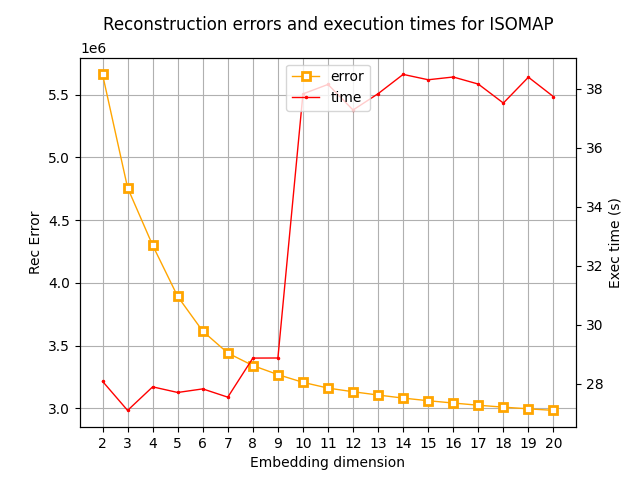

In [12]:
fig,ax=plt.subplots()
plt.xticks(range(2,up_to+1), ["%d"%k for k in range(2,up_to+1)])
ax.plot(range(2,up_to+1), IsomapD_err, label='error', color='orange', marker='s', lw=1, ms=6, mew=2,mfc='white')
ax2=ax.twinx()
ax2.plot(range(2,up_to+1), IsomapD_time, label='time', color='red', marker='.', lw=1, ms=3)
ax2.set(ylabel='Exec time (s)')
ax.set(xlabel='Embedding dimension', ylabel='Rec Error')
ax.set_title('Reconstruction errors and execution times for ISOMAP', pad=20)
ax.grid()
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
_=ax2.legend(lines + lines2, labels + labels2, loc=9)

## 2.2 Two-dimensional representations

We plot the results of the algorithms as 2-dimensional scatter plots; we also plot some images randomly selected from the dataset to have an idea of how the characteristics of the handwritten digit vary through the 2d representation.

We can recognize, in the plots for ISOMAP and LLE, two "features" of the sampled imaged that vary along the two dimensions of the scatter plot, which usually depend on the digit.

The LTSA plot does not give any insight: most of the points are collapsed very close together.

In [13]:
num_samples=20
img_nums = np.random.randint(0, len(images[digit]), size=num_samples)
ex_imgs=[images[digit][j] for j in img_nums]

In [14]:
def plot_rd(X, img_nums, ex_imgs, side_c=0, mult_side=0.08, c=[], cmap=[], legend=False):
    c=np.asarray(c)
    cmap=np.asarray(cmap)
    xval=X[:,0]
    yval=X[:,1]
    fig = plt.figure()
    fig.set_size_inches(9, 9)
    ax = fig.add_subplot(111)
    fig.set_facecolor('#111')
    if side_c==0:
        x_size = (max(xval) - min(xval)) * mult_side
        y_size = (max(yval) - min(yval)) * mult_side
    else:
        x_size=side_c
        y_size=side_c
        ax.set_aspect('equal')

    for i in range(len(img_nums)):
        img_num=img_nums[i]
        x0 = xval[img_num] - (x_size / 2.)
        y0 = yval[img_num] - (y_size / 2.)
        x1 = x0 + (x_size)
        y1 = y0 + (y_size)
        img = ex_imgs[i].reshape(28,28)
        ax.imshow(img, aspect='auto', cmap="Greys",interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))
    if not c.any():
        scatter=ax.scatter(xval,yval, alpha=0.7)
    elif not cmap.any():
        scatter=ax.scatter(xval, yval, c=c, cmap=plt.cm.Spectral)
    else:
        scatter=ax.scatter(xval, yval, c=c, cmap=cmap)
    if legend:
        legend1 = ax.legend(*scatter.legend_elements(), facecolor='#111', loc=4,labelcolor='white')
        ax.add_artist(legend1)    
    ax.axis('off')
    
    return ax
#plt.savefig('cifra2Isomap.png', format='png')


<IPython.core.display.Javascript object>


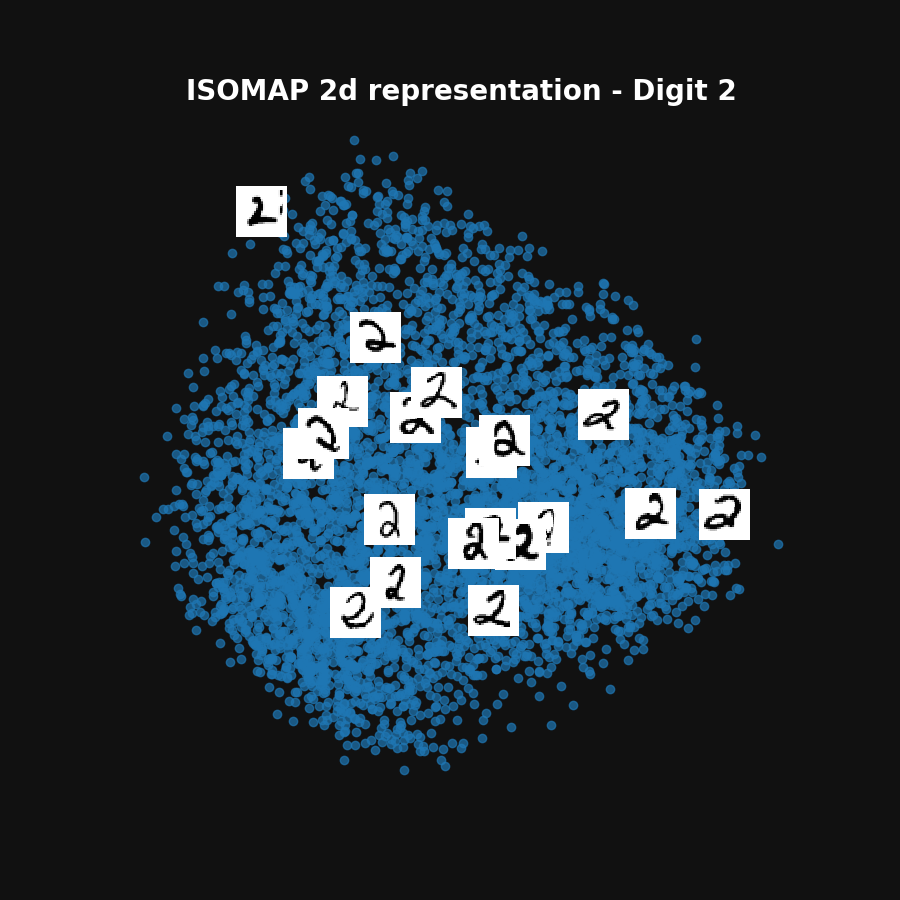

In [15]:
Isoplot=plot_rd(Isomap, img_nums, ex_imgs)
Isoplot.set_title("ISOMAP 2d representation - Digit %d"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()

<IPython.core.display.Javascript object>


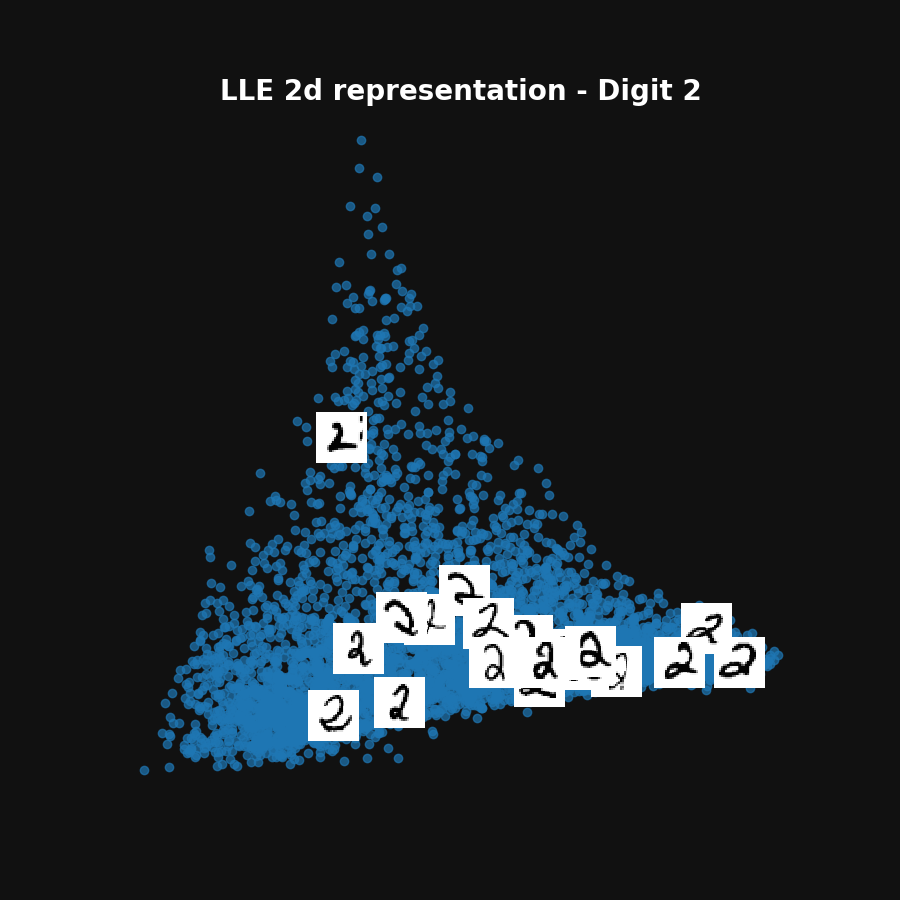

In [16]:
LLEplot=plot_rd(LLE, img_nums, ex_imgs)
LLEplot.set_title("LLE 2d representation - Digit %d"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()

<IPython.core.display.Javascript object>


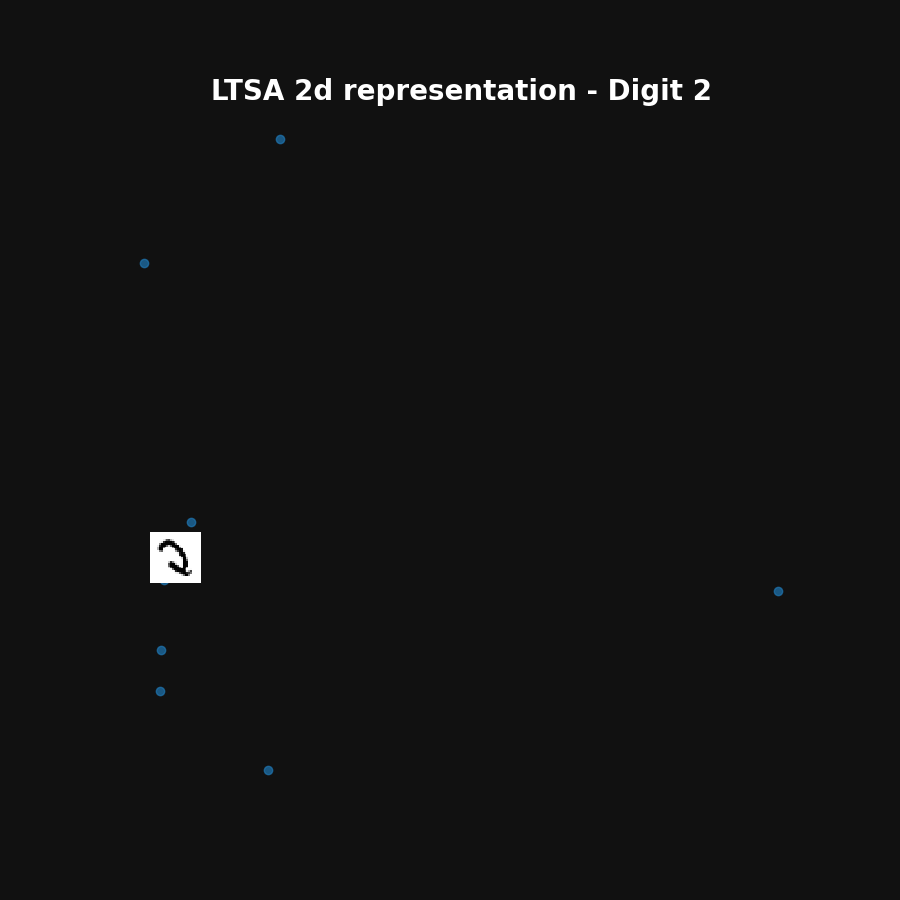

<IPython.core.display.Javascript object>


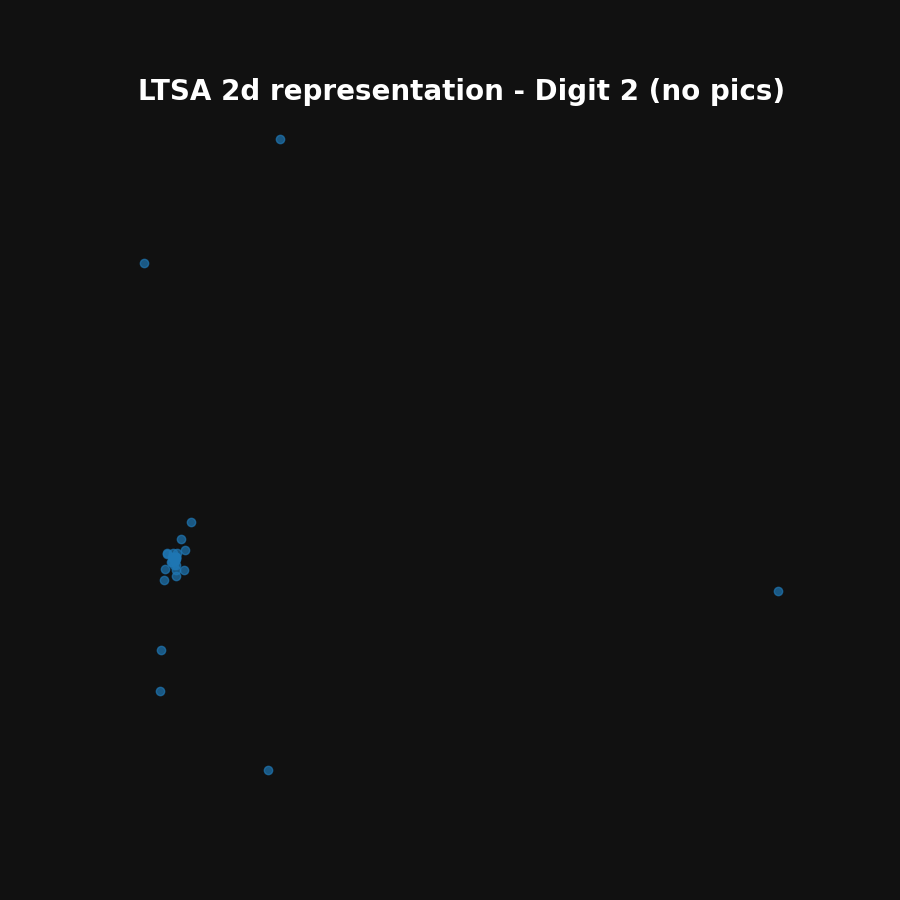

In [17]:
LTSAplot=plot_rd(LTSA, img_nums, ex_imgs)
LTSAplot.set_title("LTSA 2d representation - Digit %d"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()
# plot without the miniatures of the sample digits
LTSAplot_nd=plot_rd(LTSA, [],[])
LTSAplot_nd.set_title("LTSA 2d representation - Digit %d (no pics)"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()
xl, xu=plt.xlim()
yl, yu=plt.ylim()

### 2.2.1 What is happening with the LTSA?

Let us look more closely to LTSA results: we will compute the centroid of the results and try and decide at what scale we should be looking, in order to distinguish the points.

In [18]:
avg=np.array([np.mean(LTSA[:,0]), np.mean(LTSA[:,1])])
perc=np.array([100*np.count_nonzero(np.array([np.linalg.norm(avg-pt) for pt in LTSA])<10**(-j))/len(LTSA) for j in range(10)])
dec_dig=np.nonzero(perc<90)[0][0]-1
Dense=LTSA[np.array([np.linalg.norm(avg-pt) for pt in LTSA], dtype=np.float64)<10.**(-dec_dig)]

toll=max(np.ceil(np.log10(np.std(Dense[:,0]))),np.ceil(np.log10(np.std(Dense[:,1]))))

The centroid of the results is ({{ round(avg[0],4) }},{{ round(avg[1],4) }}); the following table shows, for the balls centered in the centroid with radius $10^{-j}$ how many points of the result lie inside such ball, in percentage.

| radius | % of points |
|:---:|:---:|
|0.0001 | {{ "%.2f%%"%(perc[4]) }}|
|0.001 | {{ "%.2f%%"%(perc[3]) }}|
|0.01 | {{ "%.2f%%"%(perc[2]) }}|
|0.1 | {{ "%.2f%%"%(perc[1]) }}|
|1 | {{ "%.2f%%"%(perc[0]) }}|

Therefore, almost all points coincide up to the {{ dec_dig }}th decimal digit; in fact, zooming in around that point, we start to see something... this is a symptom of the sensitivity of LTSA to outliers. Consider that the following plot is obtained by restricting ourselves in a neighborhood of the centroid of sizes comparable with {{ "%.1e"%(10**(toll)) }}


<IPython.core.display.Javascript object>


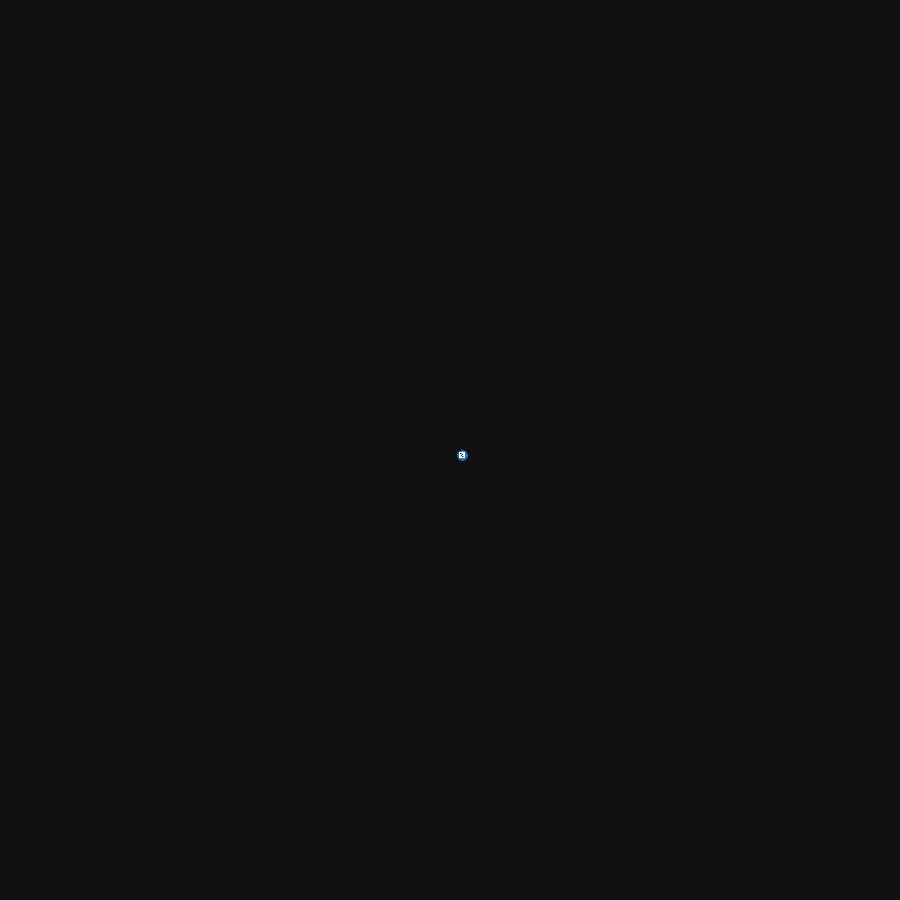

In [19]:
_=plot_rd(Dense,img_nums, ex_imgs,side_c=0.015*10**(toll))
_=plt.xlim(np.mean(Dense[:,0])-1*10**(toll),np.mean(Dense[:,0])+1*10**(toll))
_=plt.ylim(np.mean(Dense[:,1])-1*10**(toll),np.mean(Dense[:,1])+1*10**(toll))

## 2.3 Other tests

One could wonder what happens if we select only a smaller subset of images, instead of applying the algorithms to all the almost 6000 images which represent the same digit.

In [20]:
digit=2                               # the digit we want to see some samples of
num=500
sampled_img=images[digit][np.random.randint(0, len(images[digit]), size=num)]

In [21]:
KNN=30

# IsoMap algorithm on the set of images of the chosen digit
isos = manifold.Isomap(n_neighbors=KNN, n_components=2)
start=perf_counter()  # timing the algorithm
isos.fit(sampled_img)
IsomapS = isos.transform(sampled_img)
end=perf_counter()    # stop timing
IsomapS_time=end-start
IsomapS_err=isos.reconstruction_error()

# Locally Linear Embedding algorithm on the set of images of the chosen digit
lles = manifold.LocallyLinearEmbedding(n_neighbors=KNN,n_components=2)
start=perf_counter()  # timing the algorithm
lles.fit(sampled_img)
LLES=lles.transform(sampled_img)
end=perf_counter()    # stop timing
LLES_time=end-start
LLES_err=lles.reconstruction_error_

# Local Tangent Space Alignment algorithm on the set of images of the chosen digit
ltsas = manifold.LocallyLinearEmbedding(n_neighbors=KNN, n_components=2, method='ltsa', eigen_solver='dense')
start=perf_counter()  # timing the algorithm
ltsas.fit(sampled_img)
LTSAS=ltsas.transform(sampled_img)
end=perf_counter()    # stop timing
LTSAS_time=end-start
LTSAS_err=ltsas.reconstruction_error_



The algorithms performed as follows:

| Algorithm | Running time | Reconstruction error |
|:--- |:---:|:---:|
| ISOMAP | {{ "%.3f"%IsomapS_time }}s | {{ "%.2e"%IsomapS_err }} |
| LLE | {{ "%.3f"%LLES_time }}s | {{ "%.2e"%LLES_err }} |
| LTSA | {{ "%.3f"%LTSAS_time }}s | {{ "%.2e"%LTSAS_err}} |

and the plots are shown below.


<IPython.core.display.Javascript object>


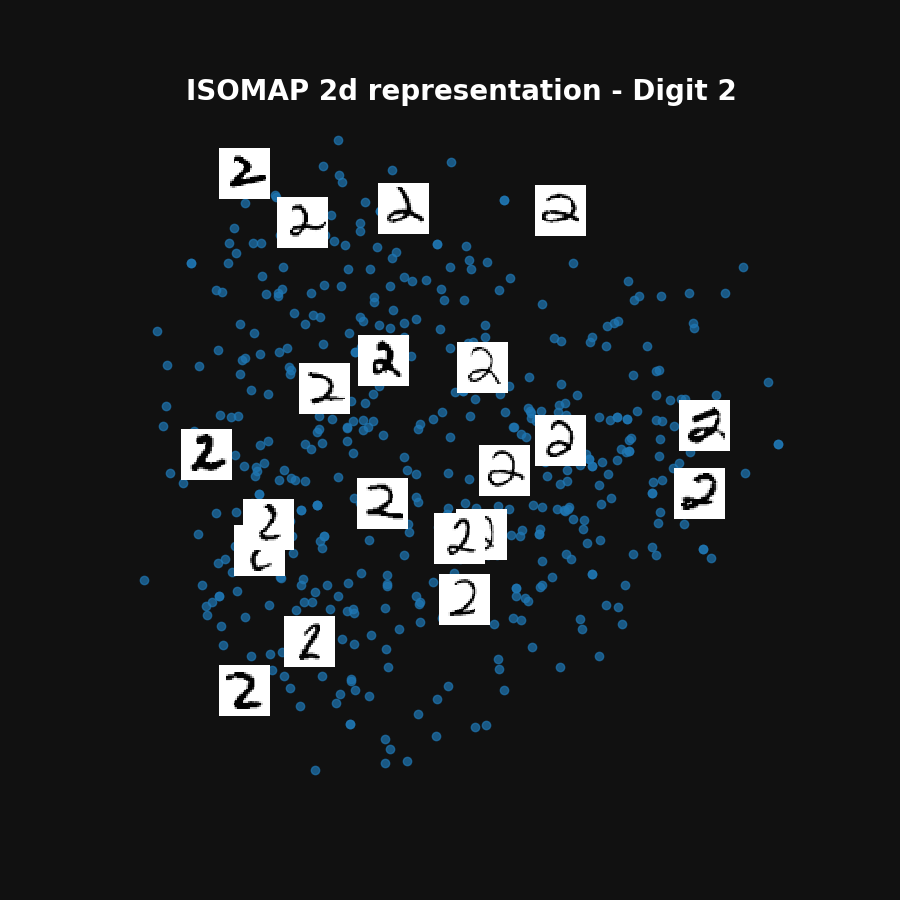

<IPython.core.display.Javascript object>


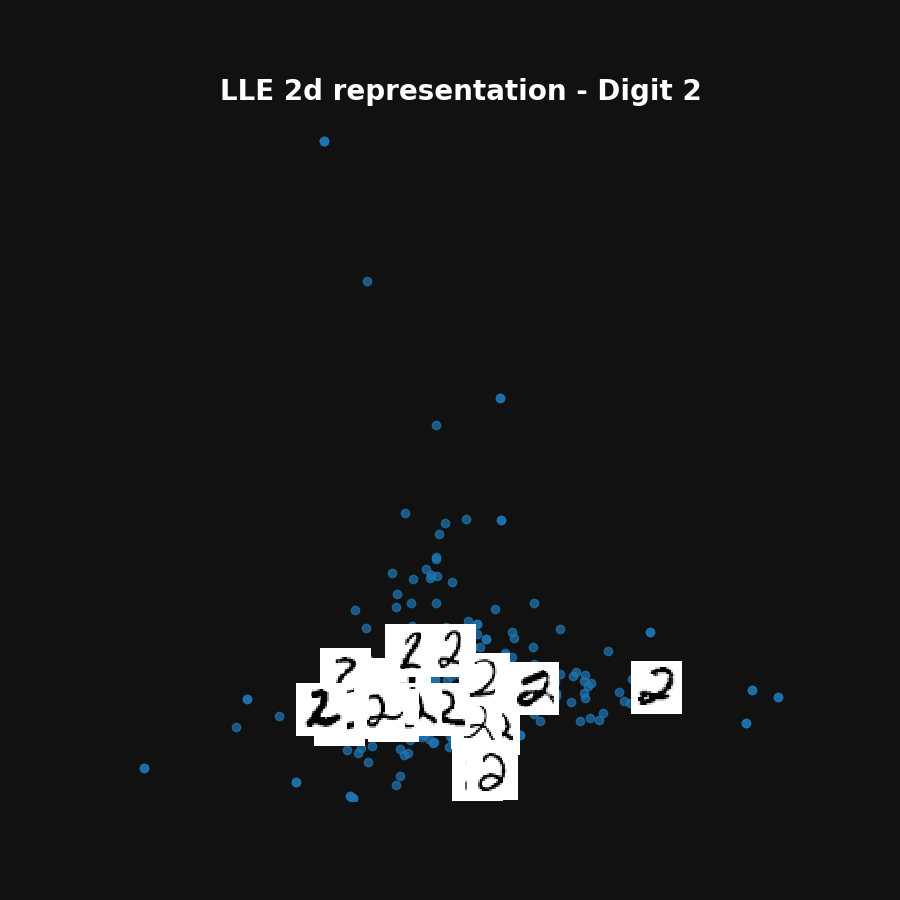

<IPython.core.display.Javascript object>


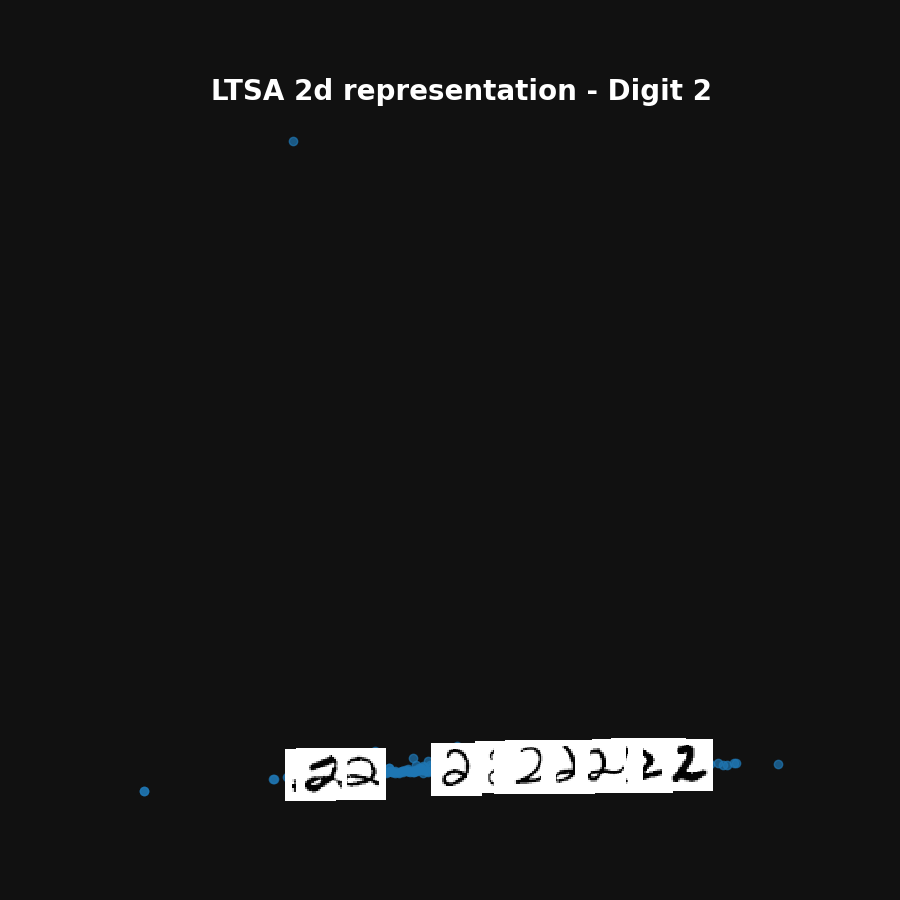

In [22]:
num_samples=20
img_nums = np.random.randint(0, len(sampled_img), size=num_samples)
ex_imgs=sampled_img[img_nums]

IsoplotS=plot_rd(IsomapS, img_nums, ex_imgs)
IsoplotS.set_title("ISOMAP 2d representation - Digit %d"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()

LLESplot=plot_rd(LLES, img_nums, ex_imgs)
LLESplot.set_title("LLE 2d representation - Digit %d"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()

LTSASplot=plot_rd(LTSAS, img_nums, ex_imgs)
LTSASplot.set_title("LTSA 2d representation - Digit %d"%digit, color='white', fontsize=20, fontweight='bold')
plt.show()

## 3. Classification problem

Another attempt we could make is to use the NLDR algorithms to try and classify the images of the whole dataset; if the algorithms recognize the "right" features, the 2d plot will separate different digits in different areas of the plane.

In order to do that, we will extract the images and the labels from the dataset without separating them according to the digit; moreover, to reduce the computation times and have a more readable plot, we will randomly select a number of images.

In [23]:
num=2000
KNN=10

img_nums = np.random.randint(0, len(train_data), size=num)
class_digits=(train_data[img_nums])[:,1:]
label_digits=(train_data[img_nums])[:,0]

isoCD = manifold.Isomap(n_neighbors=KNN, n_components=2)
start=perf_counter()
isoCD.fit(class_digits)
IsomapCD = isoCD.transform(class_digits)
end=perf_counter()
IsomapCD_time=end-start
IsomapCD_err=isoCD.reconstruction_error()


lleCD = manifold.LocallyLinearEmbedding(n_neighbors=KNN, n_components=2)
start=perf_counter()
lleCD.fit(class_digits)
LLECD = lle.transform(class_digits)
end=perf_counter()
LLECD_time=end-start
LLECD_err=lleCD.reconstruction_error_

ltsaCD = manifold.LocallyLinearEmbedding(n_neighbors=KNN, n_components=2, method='ltsa', eigen_solver='dense')
start=perf_counter()
ltsaCD.fit(class_digits)
LTSACD = ltsaCD.transform(class_digits)
end=perf_counter()
LTSACD_time=end-start
LTSACD_err=ltsaCD.reconstruction_error_

The algorithms performed as follows:

| Algorithm | Running time | Reconstruction error |
|:--- |:---:|:---:|
| ISOMAP | {{ "%.3f"%IsomapCD_time }}s | {{ "%.2e"%IsomapCD_err }} |
| LLE | {{ "%.3f"%LLECD_time }}s | {{ "%.2e"%LLECD_err }} |
| LTSA | {{ "%.3f"%LTSACD_time }}s | {{ "%.2e"%LTSACD_err}} |

and the plots are shown below.

In [24]:
num_samples=30

<IPython.core.display.Javascript object>


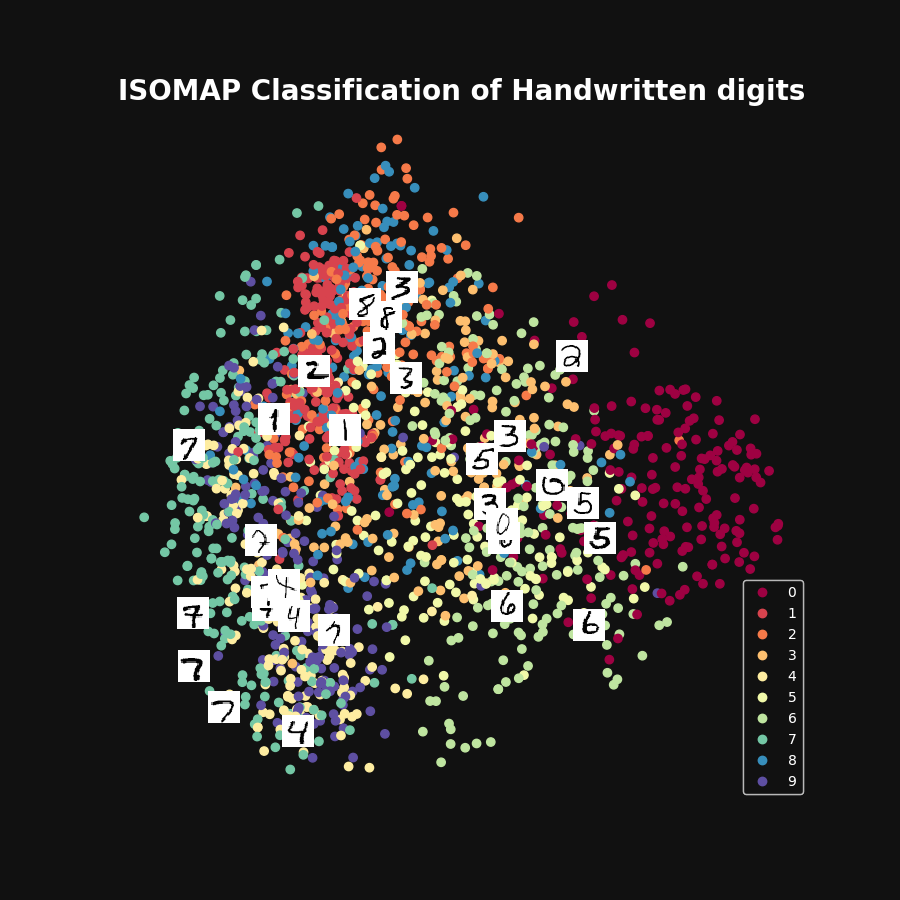

<IPython.core.display.Javascript object>


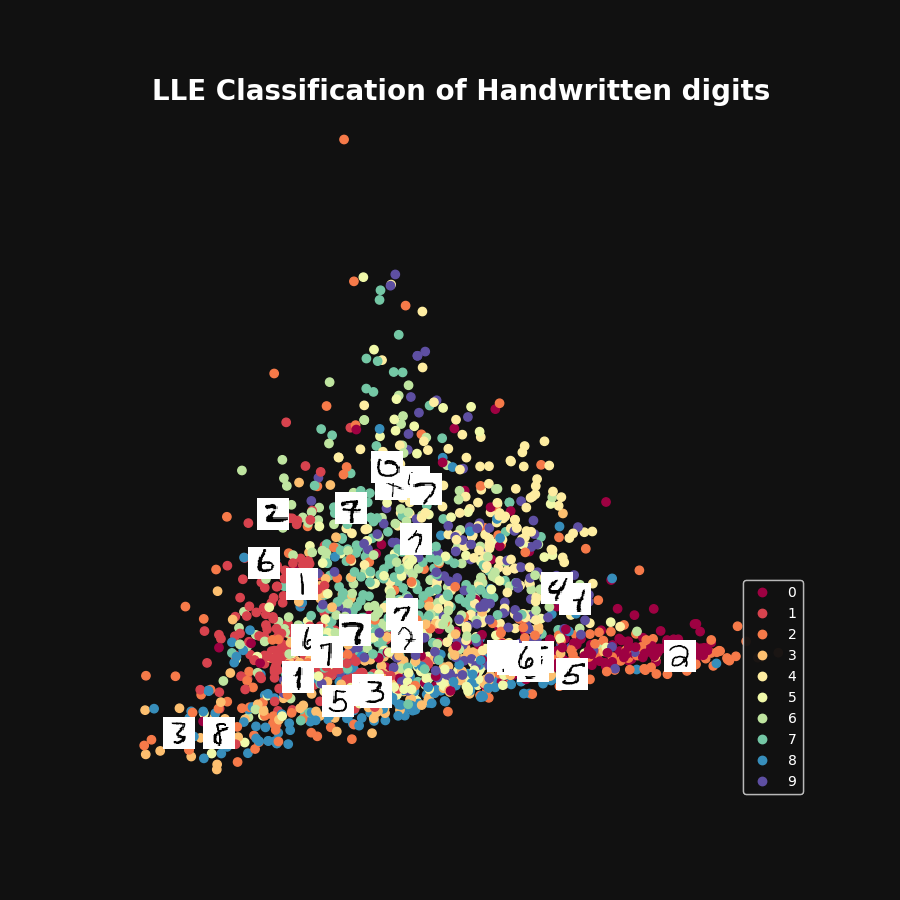

<IPython.core.display.Javascript object>


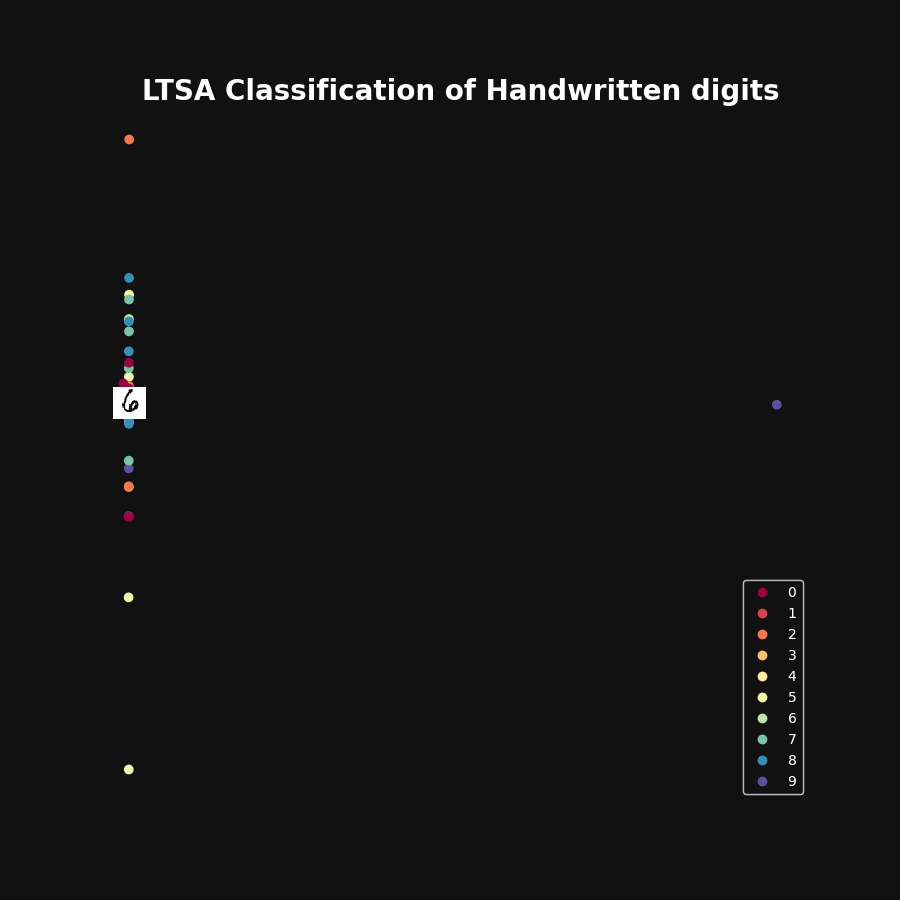

In [25]:
img_nums = np.random.randint(0, num, size=num_samples)
ex_imgs=class_digits[img_nums]

IsomapCDplot=plot_rd(IsomapCD, img_nums, ex_imgs, mult_side=0.05, c=label_digits, legend=True)
IsomapCDplot.set_title("ISOMAP Classification of Handwritten digits", color='white', fontsize=20, fontweight='bold')
plt.show()

LLECDplot=plot_rd(LLECD, img_nums, ex_imgs, mult_side=0.05, c=label_digits, legend=True)
LLECDplot.set_title("LLE Classification of Handwritten digits", color='white', fontsize=20, fontweight='bold')
plt.show()

LTSACDplot=plot_rd(LTSACD, img_nums, ex_imgs, mult_side=0.05, c=label_digits, legend=True)
LTSACDplot.set_title("LTSA Classification of Handwritten digits", color='white', fontsize=20, fontweight='bold')
plt.show()

### 3.1 Variations

It would be interesting to try and vary the number of images drawn from the dataset and even to apply the algorithms to the whole dataset; another experiment which is worth trying out is to change the value of KNN and analyze the different outputs.

On the data visualization side, one could try to replace the basic scatterplot with something more showy, for example using the characters 0,1,..,9 (with different colors) instead of dots.

Finally, the same method should be tested on different datasets, for example the digits dataset from the sklearn module.